In [2]:
#sklearn and keras 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
#for data preprocessing
from wordcloud import WordCloud
from collections import Counter
import datetime
import random
from nltk import tokenize
from operator import itemgetter
import math
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
!pip install geopandas
!pip install descartes
import geopandas as gpd


     |████████████████████████████████| 972kB 4.3MB/s 
     |████████████████████████████████| 14.8MB 284kB/s 
     |████████████████████████████████| 6.5MB 46.9MB/s 


In [5]:
#Transformation Functions for Pre-Processing
def convert_I(lis):
    list1 = []
    for i in lis:
        if i[0]!="event_id":
            if i[0]=='nan' and i[1]=='nan':# Skip nan value
                continue
            else:
                list1.append(i)
    list2 = convert_II(list1) 
    return list2

def convert_II(list1):
    i=0
    list2 = []
    while i < len(list1):
        if list1[i][0]!='nan':
            temp = list1[i]
            i+=2 
            signal = []
            disconnect = []
            while list1[i][0]=='nan': 
                signal.append(list1[i][1])
                disconnect.append(list1[i][2])
                i+=1
                if(i==len(list1)): #safety net
                    break
            temp.append(signal)
            temp.append(disconnect)
            list2.append(temp) #append df to list2
        else:
            i+=1    
    return list2 #return list2

In [76]:
add = []
for i in range(1,4):
  df1 = pd.read_excel("/content/Crime Prediction.xlsx", header=0,sheet_name=str(i))
  df = df1.iloc[:,0:16]
  df = df.replace(np.nan,'nan', regex=True)
  lis = df.values.tolist()
  lis1 = convert_I(lis)
  for item in lis1:
    add.append(item)
print("Number of Entries after cleaning data: ",len(add))

Number of Entries after cleaning data:  801


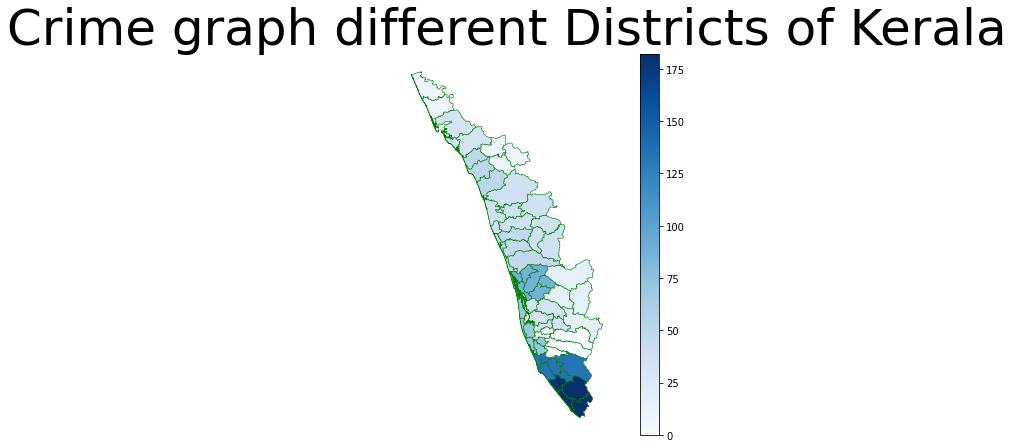

In [77]:
  count = {}
  for i in add:
    if i[4] not in count:
      count[i[4]] = 1
    else:
      count[i[4]] +=1
  ls = []
  for i in count.keys():
    if(i=="nan"):
      continue
    temp = []
    temp.append(i)
    temp.append(count[i])
    ls.append(temp)
  district_wise=pd.DataFrame(ls)
  fp = "/content/drive/MyDrive/IND_adm/IND_adm/IND_adm3.shp"
  map_df = gpd.read_file(fp)
  map_df = map_df[['NAME_1', 'NAME_2', 'geometry']]
  map_df = map_df[map_df['NAME_1']=='Kerala']
  merged = map_df.set_index('NAME_2').join(district_wise.set_index(0))
  merged[1].fillna(0, inplace=True)
  fig, ax = plt.subplots(1, figsize=(10, 7))
  ax.axis('off')
  ax.set_title('Crime graph different Districts of Kerala', fontdict={'fontsize': '50', 'fontweight' : '10'})
  # plot the figure
  merged.plot(column=1, cmap='Blues', linewidth=0.6, ax=ax, edgecolor='green',legend=True)

In [78]:
#create parse_time and convert_time function
def parse_time(text):
  sep = '.'
  stripped = text.split(sep, 1)[0]
  return stripped

def convert_time(date_time1,date_time2):
  string1 = parse_time(date_time1)
  string2 = parse_time(date_time2)
  format = "%Y-%m-%d %H:%M:%S"
  datetime_str1 = datetime.datetime.strptime(string1, format)
  datetime_str2 = datetime.datetime.strptime(string2, format)
  time = str(datetime_str2 - datetime_str1)
  return sum(x * int(t) for x, t in zip([60, 1, 1/60], time.split(":")))

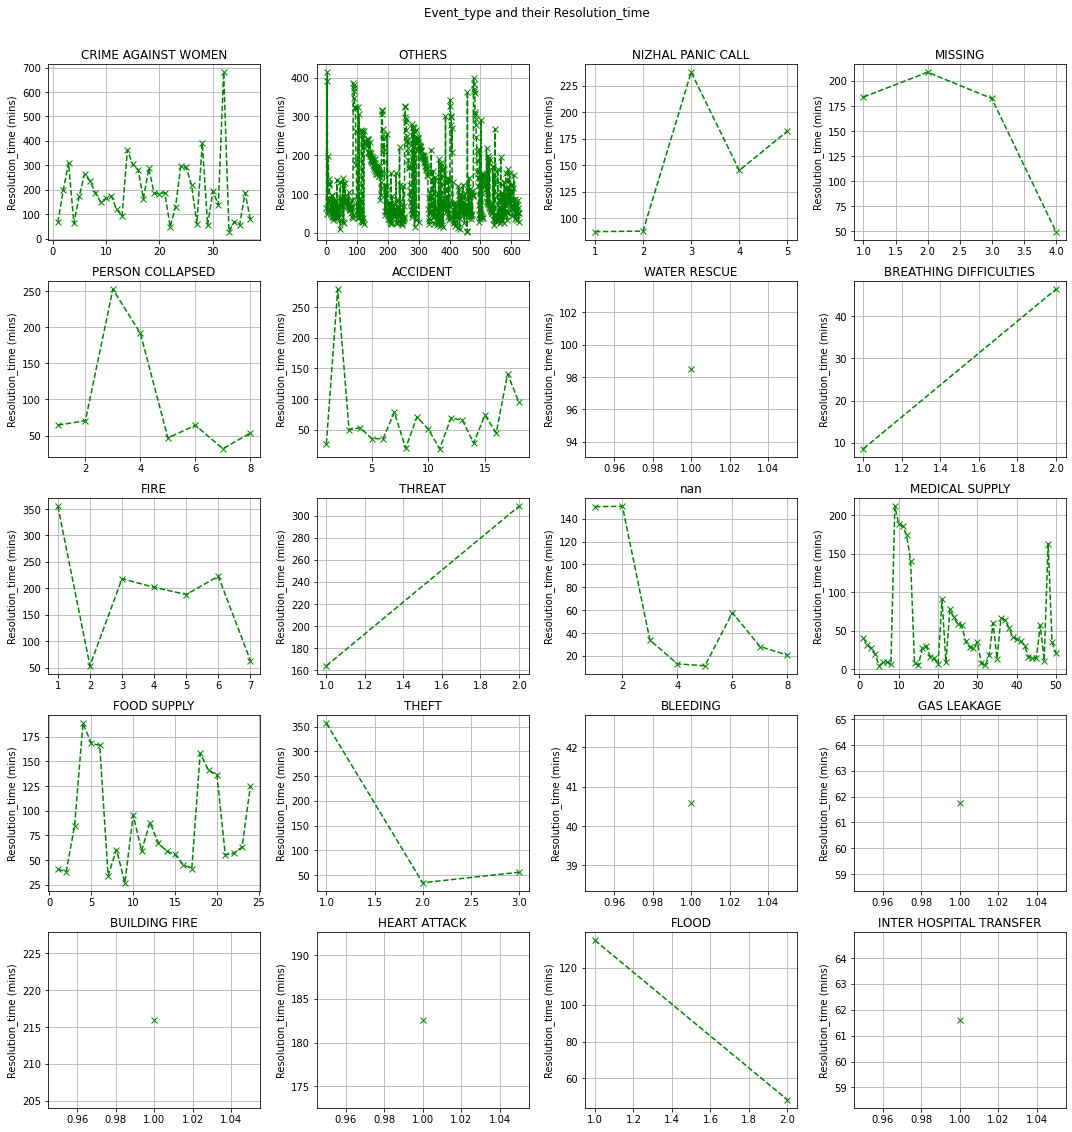

In [156]:
#Plotting Event type and their Resolution time
dic = {}
for i in add:
  if(i[2] in dic.keys()):
    dic[i[2]].append(convert_time(i[1],i[11]))
  else:
    dic[i[2]] = [convert_time(i[1],i[11])]
fig = plt.figure(figsize=(15, 16))
fig.suptitle('Event_type and their Resolution_time',fontsize=12)
fig.subplots_adjust(hspace = .3, wspace=.001)
for key,it in zip(dic,range(1,21)):
  index = []
  for i in range(1,len(dic[key])+1):
    index.append(i)
  ax = fig.add_subplot(5,4,it)
  ax.plot(index,dic[key], color='green',marker='x',lineStyle='--')
  ax.set_title(key)
  ax.set_ylabel('Resolution_time (mins)')
  ax.grid(True)
plt.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()

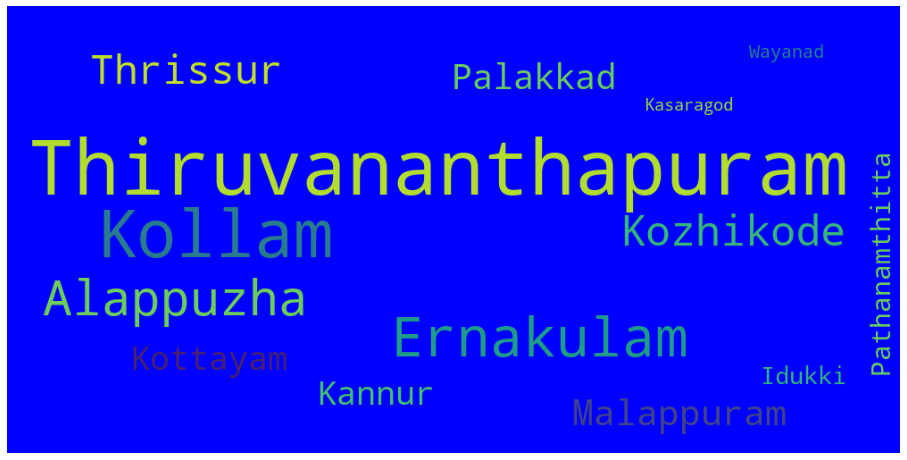

In [104]:
#WordCloud for Crimes Reported per district
ls = []
for i in add:
  if i[4]=="nan":
    continue
  ls.append(i[4])
word_could_dict=Counter(ls)
wordcloud = WordCloud(width = 1000, height = 500,collocations=False,background_color='blue').generate_from_frequencies(word_could_dict)
plt.figure(figsize=(16,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [80]:
#Using NLTK
string = ""
for i in add:
  if(i[2]=="OTHERS"):
    string += str(i[15])
string = string.strip('\n')
stops = ["caller","informed","callers","PS",'ps','loc:','PS,','!','@','#','$','%','^','&','*','-','_',':',";",',','.','loc;','SAYS','IN','fish']
stop_words = set(stopwords.words('english'))
for i in stops:
  stop_words.add(i)
total_words = string.split()
total_word_length = len(total_words)
total_sentences = tokenize.sent_tokenize(string)
total_sent_len = len(total_sentences)
tf_score = {}
for each_word in total_words:
    each_word = each_word.replace('.','')
    if each_word not in stop_words:
        if each_word in tf_score:
            tf_score[each_word] += 1
        else:
            tf_score[each_word] = 1

# Dividing by total_word_length for each dictionary element
tf_score.update((x, y/int(total_word_length)) for x, y in tf_score.items())

def check_sent(word, sentences): 
    final = [all([w in x for w in word]) for x in sentences] 
    sent_len = [sentences[i] for i in range(0, len(final)) if final[i]]
    return int(len(sent_len))

idf_score = {}
for each_word in total_words:
    each_word = each_word.replace('.','')
    if each_word not in stop_words:
        if each_word in idf_score:
            idf_score[each_word] = check_sent(each_word, total_sentences)
        else:
            idf_score[each_word] = 1

idf_score.update((x, math.log(int(total_sent_len)/y)) for x, y in idf_score.items())

tf_idf_score = {key: tf_score[key] * idf_score.get(key, 0) for key in tf_score.keys()}

def get_top_n(dict_elem, n):
    result = dict(sorted(dict_elem.items(), key = itemgetter(1), reverse = True)[:n]) 
    return result

keywords = get_top_n(tf_idf_score,5)
print("Top Keywords are:")
for key in keywords.keys():
  print(key)

Top Keywords are:
gathered
near
people
gathering
shop


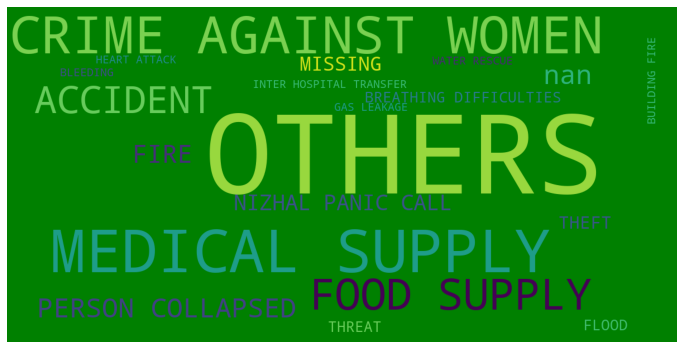

In [101]:
#after using nltk on Word Cloud
ls = []
for i in add:
  if(i[3]=="OTHERS"):
    string = str(i[14])
    string = string.lower()
    if("gather" in string or "crowd" in string):
        ls.append("Crowd Gathering")
    else:
        ls.append("Others")
  else:
    ls.append(i[2])
word_could_dict=Counter(ls)
wordcloud = WordCloud(width = 1200, height = 600,background_color='green',
                      collocations=False).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [83]:
def check_slot(time):
  string1 = parse_time(time)
  format = "%Y-%m-%d %H:%M:%S"
  datetime_str1 = datetime.datetime.strptime(string1, format)
  tmp = str(datetime_str1)
  tmp = tmp.split(" ",1)[1]
  mins = sum(x * int(t) for x, t in zip([60, 1, 1/60], tmp.split(":")))
  if(mins<240):
    return "slot1"
  elif(240<=mins<480):
    return "slot2"
  elif(480<=mins<720):
    return "slot3"
  elif(720<=mins<960):
    return "slot4"
  elif(960<=mins<1200):
    return "slot5"
  else:
    return "slot6"

lis = []
for i in add:
  tmp = []
  tmp.append(check_slot(i[1]))
  tmp.append(i[4])
  if(i[2]=="nan"):
    continue
  elif(i[2]=="OTHERS"):
    string = str(i[15])
    string = string.lower()
    if("gather" in string or "crowd" in string):
        tmp.append("Crowd Gathering")
    else:
        tmp.append("Others")
  else:
    tmp.append(i[2])
  lis.append(tmp)

In [132]:
#Using Logistic Regression for Classification
reg = pd.DataFrame(lis)
ord_enc = OrdinalEncoder()
reg["time"] = ord_enc.fit_transform(reg[[0]])
reg["district"] = ord_enc.fit_transform(reg[[1]])
reg["crime"] = ord_enc.fit_transform(reg[[2]])

x = reg.iloc[:, [3, 4]].values 
y = reg.iloc[:, 5].values

xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.25, random_state = 0)
 
LiR1 = LogisticRegression(random_state = 0,solver='lbfgs',max_iter=10000000)
LiR1.fit(xtrain, ytrain)
y_pred = LiR1.predict(xtest)

print ("Accuracy using lbfgs solver: ",accuracy_score(ytest, y_pred))

LiR2 = LogisticRegression(random_state = 0,solver='saga',max_iter=10000000)
LiR2.fit(xtrain, ytrain)
y_pred = LiR2.predict(xtest)

print ("Accuracy using saga solver: ",accuracy_score(ytest, y_pred))

Accuracy using lbfgs solver:  0.41708542713567837
Accuracy using saga solver:  0.41708542713567837


In [143]:
# Using Gradient Boosting Classifire
from sklearn.ensemble import GradientBoostingClassifier
x = reg.iloc[:, [3, 4]].values 
y = reg.iloc[:, 5].values
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.20, random_state = 0)
gbrclassifier = GradientBoostingClassifier(random_state=0,criterion='mse')
gbrclassifier.fit(xtrain, ytrain)
y_pred = gbrclassifier.predict(xtest)
print(gbrclassifier.score(xtest, ytest))

0.5408805031446541


In [144]:
# Using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
x = reg.iloc[:, [3, 4]].values 
y = reg.iloc[:, 5].values
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.20, random_state = 0)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(xtrain, ytrain)
y_pred = clf.predict(xtest)
print(gbrclassifier.score(xtest, ytest))

0.5408805031446541


In [114]:
#Using SVM algorithm
x = reg.iloc[:, [3, 4]].values 
y = reg.iloc[:, 5].values
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.20, random_state = 0)
svclassifier = SVC(kernel='linear')
svclassifier.fit(xtrain, ytrain)
y_pred = svclassifier.predict(xtest)
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         8
         5.0       0.00      0.00      0.00        60
         6.0       0.00      0.00      0.00         1
         8.0       0.00      0.00      0.00         5
        12.0       0.75      0.38      0.50         8
        13.0       0.00      0.00      0.00         1
        15.0       0.45      1.00      0.62        69
        16.0       0.00      0.00      0.00         2
        18.0       0.00      0.00      0.00         1

    accuracy                           0.45       159
   macro avg       0.11      0.12      0.10       159
weighted avg       0.23      0.45      0.29       159



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [155]:
#using linear regression
from sklearn.linear_model import LinearRegression
x = reg.iloc[:, [3, 4]].values 
y = reg.iloc[:, 5].values
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.20, random_state = 0)
lr = LinearRegression().fit(xtrain, ytrain)
lr.score(xtest, ytest)
y_pred = lr.predict(xtest)
print(100*lr.score(xtest, ytest))

0.9539783734542229


In [136]:
#Using K-Nearest neighbor
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
x = reg.iloc[:, [3, 4]].values 
y = reg.iloc[:, 5].values
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.20, random_state = 0)
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(xtrain, ytrain)
y_pred = knn.predict(xtest)
print(knn.score(xtest, ytest))
print(confusion_matrix(ytest, y_pred))
print(classification_report(ytest, y_pred))

0.5031446540880503
[[ 0  0  0  1  0  0  0  0  2  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  3  0  0]
 [ 0  0  0 44  0  0  2  0 14  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  1  0  1  1  0  2  0  0]
 [ 0  0  0  2  0  0  3  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  1 34  0  0  2  0 32  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         8
         5.0       0.49      0.73      0.59        60
         6.0       0.00      0.00      0.00         1
         8.0       1.00      0.20      0.33         5
        12.0       0.38      0.38      0.38         8
        13.0       0.00      0.00      0.00         1
        15.0       0.54      0.46      0.50        69
        16.0       0.00      0.00      0.00

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [133]:
#MLP Classifire
from sklearn.neural_network import MLPClassifier
x = reg.iloc[:, [3, 4]].values 
y = reg.iloc[:, 5].values
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.20, random_state = 0)
MLP = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
MLP.fit(xtrain,ytrain)
y_pred = MLP.predict(xtest)
print(MLP.score(xtest, ytest))

0.39622641509433965


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [134]:
#Using Deep Learning for Classification
x = reg.iloc[:, [3, 4]].values 
y = reg.iloc[:, 5].values
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.20, random_state = 0)
model = Sequential()
model.add(Dense(8, input_dim=xtrain.shape[1], activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.fit(xtrain, ytrain, epochs=30, batch_size=10, verbose=2)
_, accuracy = model.evaluate(xtest, ytest, verbose=0)
print('Accuracy: %.2f using Deep Learning' % (accuracy*100))

Epoch 1/30
64/64 - 0s - loss: -4.8358e+01 - accuracy: 0.0000e+00
Epoch 2/30
64/64 - 0s - loss: -4.8405e+01 - accuracy: 0.0000e+00
Epoch 3/30
64/64 - 0s - loss: -4.8454e+01 - accuracy: 0.0000e+00
Epoch 4/30
64/64 - 0s - loss: -4.8505e+01 - accuracy: 0.0000e+00
Epoch 5/30
64/64 - 0s - loss: -4.8557e+01 - accuracy: 0.0000e+00
Epoch 6/30
64/64 - 0s - loss: -4.8610e+01 - accuracy: 0.0000e+00
Epoch 7/30
64/64 - 0s - loss: -4.8665e+01 - accuracy: 0.0000e+00
Epoch 8/30
64/64 - 0s - loss: -4.8720e+01 - accuracy: 0.0000e+00
Epoch 9/30
64/64 - 0s - loss: -4.8776e+01 - accuracy: 0.0000e+00
Epoch 10/30
64/64 - 0s - loss: -4.8834e+01 - accuracy: 0.0000e+00
Epoch 11/30
64/64 - 0s - loss: -4.8893e+01 - accuracy: 0.0000e+00
Epoch 12/30
64/64 - 0s - loss: -4.8953e+01 - accuracy: 0.0000e+00
Epoch 13/30
64/64 - 0s - loss: -4.9013e+01 - accuracy: 0.0000e+00
Epoch 14/30
64/64 - 0s - loss: -4.9074e+01 - accuracy: 0.0000e+00
Epoch 15/30
64/64 - 0s - loss: -4.9137e+01 - accuracy: 0.0000e+00
Epoch 16/30
64/64 -